In [1]:
import itertools

import imageio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

np.random.seed(1)

## Exercise 1

#### Load data

In [2]:
((train_images, train_labels), (test_images, test_labels)) = mnist.load_data()
train_images = np.expand_dims(train_images, axis=-1)
train_images = train_images/255
test_images = np.expand_dims(test_images, axis=-1)
test_images = test_images/255

#### Define model

In [3]:
model = keras.Sequential(
    [
        layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3), activation="relu"),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3), activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ]
)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

#### Compile, fit, evaluate

In [5]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [6]:
model.fit(train_images, train_labels, batch_size=64, epochs=5,validation_split=0.2, verbose=1)

Epoch 1/5
750/750 [==============================] - 13s 16ms/step - loss: 0.4703 - accuracy: 0.8483 - val_loss: 0.0866 - val_accuracy: 0.9747
Epoch 2/5
750/750 [==============================] - 14s 19ms/step - loss: 0.0559 - accuracy: 0.9829 - val_loss: 0.0483 - val_accuracy: 0.9850
Epoch 3/5
750/750 [==============================] - 14s 19ms/step - loss: 0.0333 - accuracy: 0.9897 - val_loss: 0.0404 - val_accuracy: 0.9888
Epoch 4/5
750/750 [==============================] - 14s 19ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.0541 - val_accuracy: 0.9865
Epoch 5/5
750/750 [==============================] - 14s 19ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.0394 - val_accuracy: 0.9902


In [7]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0302 - accuracy: 0.9905


[0.030167868360877037, 0.9904999732971191]

## Exercise 2

#### Load image

In [8]:
# NB: imageio reads rgb values as integers from 0 to 255
img = imageio.imread('einstein.jpg')

In [9]:
img = img[:,:,0]
img = img/255

#### Define kernels

In [10]:
sobel_x = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

In [11]:
sobel_y = sobel_x.T

In [12]:
def apply_sobel(image, conv_fn):
    conv_x = conv_fn(image, sobel_x)
    conv_y = conv_fn(image, sobel_y)
    conv_x_y = np.sqrt(conv_x**2+conv_y**2)
    return conv_x_y / conv_x_y.max()

#### Using scipy convolve2d function

In [13]:
convolve2d_valid = lambda x,y: convolve2d(x,y, mode='valid')
result = apply_sobel(img, convolve2d_valid)

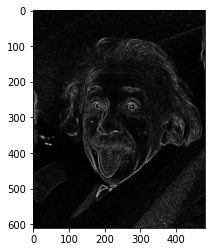

In [14]:
plt.imshow(result,cmap='gray')

#### Using custom convolution function

In [15]:
def compute_convolution_at_position(i,j,image,kernel):
    result_ij = 0.0
    for k in range(kernel.shape[0]):
        for l in range(kernel.shape[1]):
            result_ij += image[i+k,j+l] * kernel[k,l]
    return result_ij

In [16]:
def our_conv(image, kernel):
    result_rows = image.shape[0] - kernel.shape[0] + 1
    result_cols = image.shape[1] - kernel.shape[1] + 1
    indices = itertools.product(range(result_rows),range(result_cols))
    res_vec = [compute_convolution_at_position(idx_x,idx_y,image,kernel) for idx_x,idx_y in indices]
    return np.array(res_vec).reshape((result_rows, result_cols))

In [17]:
our_result = apply_sobel(img, our_conv)

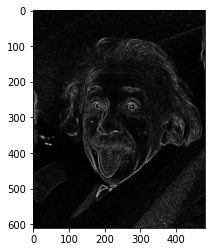

In [18]:
plt.imshow(our_result,cmap='gray')

## Exercise 3

#### Custom gradient function

In [19]:
# NB: indices needed slight adjustment due to 0 indexing of python arrays
def conv_gradient_wrt_input(dloss_dy, kernel):
    image_rows = dloss_dy.shape[0] + kernel.shape[0] - 1
    image_cols = dloss_dy.shape[1] + kernel.shape[1] - 1
    indices = itertools.product(range(image_rows),range(image_cols))
    
    gradients=[]

    for i,j in indices:
        lk = max(0, i - image_rows + kernel.shape[0])
        ll = max(0, j - image_cols + kernel.shape[1])
        uk = min(kernel.shape[0],i+1)
        ul = min(kernel.shape[1],j+1)

        gradient_ij = 0.0
        for k in range(lk,uk):
            for l in range(ll,ul):
                a = i - k
                b = j - l
                gradient_ij += dloss_dy[a, b] * kernel[k,l]
        gradients.append(gradient_ij)
    
    return np.array(gradients).reshape((image_rows, image_cols)) 

In [20]:
result = our_conv(img,sobel_x)

In [21]:
input_gradient = conv_gradient_wrt_input(2*result, sobel_x)

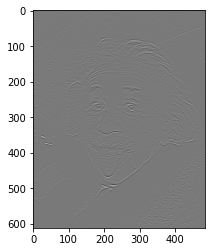

In [22]:
normalized = (input_gradient - input_gradient.min())/(input_gradient.max()-input_gradient.min())
plt.imshow(normalized,cmap='gray')

#### Numerical validation of gradient function

In [23]:
eps = 1e-6
i = np.random.randint(img.shape[0])
j = np.random.randint(img.shape[1])

img[i,j] += eps
conv_pos = our_conv(img, sobel_x)

img[i,j] -= 2*eps
conv_neg = our_conv(img, sobel_x)

img[i,j] += eps

empirical_gradient = (conv_pos**2 - conv_neg**2).sum()/(2 * eps)

In [24]:
empirical_gradient, input_gradient[i,j]

(-1.0509803921566163, -1.0509803921568612)

#### Gradient ascent

In [25]:
maxim = np.random.uniform(0,1,(9,9))

In [26]:
losses = []
for i in range(250):
    conv = our_conv(maxim, sobel_x)
    loss = (conv**2).sum()
    grad = conv_gradient_wrt_input(2 * conv, sobel_x)
    maxim += 0.01 * grad
    losses.append(loss)

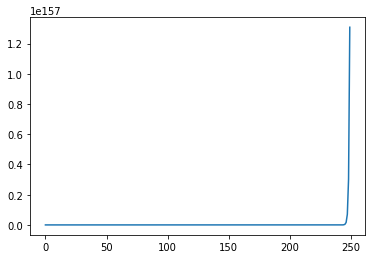

In [27]:
plt.plot(losses)

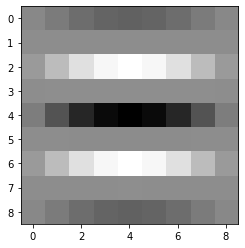

In [28]:
plt.imshow(maxim,cmap='gray')